![WireGuard Logo](https://www.wireguard.com/img/wireguard.svg)

##### Note: If any of the images are not loading, the full code (as well as `.pcap` and `.png` files can be found on [GitHub](https://github.com/JannisHajda/modern-and-secure-internet/tree/main/assignment01)

### 1. Install/import necessary libraries
First, we need to install the WireGuard package on both the server and client to handle WireGuard configuration and key management.

```bash
# Install WireGuard package for managing VPN (Debian based)
sudo apt install wireguard

# Installing WireGuard on MacOS using Homebrew:
brew install wireguard
```

If we want to configure WireGuard using Python, we additionally need to install the `python-wireguard` package.

```bash
pip install python-wireguard
```

### 2. Generate WireGuard keys (as needed)
To establish a secure connection, we need to generate a public-private key pair on both the server and client:
- The private key remains secret on each device.
- The public key is shared with the other device to establish a secure connection.

Using bash:
```bash
# Generate private key and pipe it to create the public key
wg genkey | tee privatekey | wg pubkey > publickey
```

Using Python with the `python-wireguard` library:
```python
# Import Key class from python_wireguard to generate keys in Python
from python_wireguard import Key

# Generate private and public key pair for WireGuard
private, public = Key.key_pair()
```

### 3. Set up WireGuard Server (or/and use a WireGuard test server)
Manual Configuration in `/etc/wireguard/wg0.conf`:

```bash
# WireGuard server configuration

[Interface]
# Server IP and subnet for VPN
Address = 10.0.0.1/24
ListenPort = 51820
PrivateKey = <server-private-key>

[Peer]
PublicKey = <client-public-key>
# Allow only the client IP to connect
AllowedIPs = 10.0.0.2/32
```

Using `python-wireguard` to configure the server:
```python
# Import necessary classes to set up server configuration in Python
from python_wireguard import Server, ClientConnection

# Create and enable WireGuard server with interface name, private key, IP, and port
server = Server("wg0", private, "10.0.0.1/24", 51820)
server.enable()

# Set up client connection with client's public key and IP
client_public_key = Key("<client-public-key>")
client_ip = "10.0.0.2"
conn = ClientConnection(client_public_key, client_ip)

# Add client connection to the server
server.add_client(conn)
```

### 4. Set up the client connection
Manual Configuration in `/etc/wireguard/wg0.conf`:

```bash
# WireGuard client configuration

[Interface]
# Client IP and subnet for VPN (needs to match the server's AllowedIPs)
Address = 10.0.0.2/24
PrivateKey = <client-private-key>

[Peer]
PublicKey = <server-public-key>
# Allowed IP range to be routed through the VPN tunnel (e.g., 0.0.0.0/0 for all traffic)
# In this case, only traffic to 10.0.0.1 is routed through the tunnel
AllowedIPs = 10.0.0.1/32
# Server's public IP and the WireGuard listening port
Endpoint = 89.58.29.203:51820
# Keep the connection alive, if no traffic is sent (every 30 seconds)
PersistentKeepalive = 30
```

Using `python-wireguard` to configure the client:
```python
from python_wireguard import Client, ServerConnection, Key

# Create WireGuard client with interface name, private key, and IP (needs to match servers client_ip)
client = Client("wg0", private, "10.0.0.2/24")

# Define server connection details
server_public_key = Key("<server-public-key>")
server_ip = "89.58.29.203"
server_port = 51820

# Set up server connection in client configuration
server_conn = ServerConnection(server_public_key, server_ip, server_port)
client.set_server(server_conn)
```

### 5. Connect the client to the server (WireGuard)
Once both configurations are configured, start the WireGuard connection on both the server and the client:

Using Command Line (on both server and client):
```bash
# Bring up the WireGuard interface and establish the connection
wg-quick up wg0
```

Using `python-wireguard` (on the client):
```python
client.connect()
```

### 6. Capture network packets
To analyze the behavior of the network traffic between the client and server during various stages of the VPN connection, I set up a controlled test environment that captures packets at critical points. The objective was to observe the transition of network traffic before establishing the WireGuard tunnel, during its operation, and after its termination, as well as to examine the effects of the PersistentKeepalive setting on the connection's stability.

```bash
#!/bin/bash

# Start tcpdump on en0 for the external IP and the WireGuard internal IP
echo "Starting tcpdump on en0 for external and VPN internal IP..."
sudo tcpdump -i en0 host 89.58.29.203 or host 10.0.0.1 -w en0_traffic.pcap &
TCPDUMP_EN0_PID=$!                 # Store the PID of tcpdump on en0

# Start continuous ping to 10.0.0.1 in the background
ping 10.0.0.1 > /dev/null & # Log output to a file for reference
PING_PID=$!                 # Store the PID of the ping process to manage it

# Wait a moment to capture initial pings on en0
sleep 10

# Bring up the WireGuard interface
echo "Starting WireGuard interface..."
sudo wg-quick up wg0

# Start tcpdump on utun5 (the WireGuard interface) to capture decrypted traffic
echo "Starting tcpdump on utun5 to capture VPN traffic..."
sudo tcpdump -i utun5 -w utun5_traffic.pcap &
TCPDUMP_WG0_PID=$!                 # Store the PID of tcpdump on utun5

# Wait 10 seconds with ping running on WireGuard
sleep 10

# Stop the ping process to observe automatic handshakes
echo "Pausing the ping process for 30 seconds..."
kill $PING_PID
sleep 30

# Resume pinging for 10 seconds
echo "Resuming the ping process..."
ping 10.0.0.1 > /dev/null &
PING_PID=$!
sleep 10

# Stop tcpdump on utun5
echo "Stopping tcpdump on utun5..."
sudo kill $TCPDUMP_WG0_PID

# Bring down the WireGuard interface
echo "Stopping WireGuard interface..."
sudo wg-quick down wg0

# Stop the ping process again and wait an additional 10 seconds to observe final traffic
echo "Letting ping process run for 10 more seconds..."
sleep 10
kill $PING_PID

# Stop tcpdump on en0
echo "Stopping tcpdump on en0..."
sudo kill $TCPDUMP_EN0_PID

echo "Capture complete. PCAP files saved as en0_traffic.pcap and utun5_traffic.pcap"
```

We begin by initiating network traffic capture using tcpdump on the default network interface, which is `en0` in our setup. The capture is configured to filter and record traffic associated specifically with the external server IP address (89.58.29.203) and the server's internal WireGuard IP (10.0.0.1). After setting up the capture, we commence a continuous ping to the server's internal WireGuard IP for approximately 10 seconds. This initial pinging serves to generate traffic that can be observed in the capture before the VPN connection is established, illustrating the baseline network behavior.

Following the initial capture and ping, we establish the WireGuard VPN connection by executing the command `wg-quick up wg0`. Concurrently, we start a new tcpdump capture on the WireGuard network interface, designated as `utun5` in our environment. This additional capture enables us to monitor the decrypted VPN traffic within the tunnel. We then continue pinging the server's internal WireGuard IP for another 10 seconds. This period allows us to inspect and compare the packet flow on both the default and VPN interfaces, highlighting the differences in traffic before and after the establishment of the WireGuard connection.

With the VPN connection active and after 10 seconds of pinging, we pause the ping process for 30 seconds. This pause is intentional to observe the behavior of the configured PersistentKeepalive setting within WireGuard. By halting active traffic, we can assess whether the keepalive packets are being sent at the specified intervals to maintain the VPN connection despite the inactivity, which is crucial for sustaining connections through NATs and firewalls that may drop idle sessions.

After the 30-second pause, we resume the pinging process for an additional 10 seconds. This step helps us verify if the VPN tunnel remains active and responsive after a period of inactivity, and whether any new handshakes are required to re-establish communication. Subsequently, we terminate the WireGuard connection using `wg-quick down wg0`, which also stops the network traffic capture on the `utun5` interface. We then continue pinging for a final 10 seconds without the VPN connection, allowing us to observe the network behavior and packet flow when the secure tunnel is no longer in place. Finally, we stop the network traffic capture on the `en0` interface, concluding the data collection phase of our experiment. The output of both captures are stored as `PCAP` files named `en0_traffic.pcap` and `utun5_traffic.pcap` for subsequent analysis.

### 7. Analyze captured network packets
To analyze the captured network packets, we use Python’s `scapy` library to parse the `.pcap` files and extract relevant packet details. We defined helper functions to classify each packet by protocol and direction. This `determine_protocol()` function, inspects the IP layer to classify each packet as TCP, UDP, ICMP, or “OTHER” if it doesn’t match these types. The `determine_direction()` function identifies packet direction by checking source and destination IP addresses. If a packet moves from an internal to an external IP, it is labeled `OUTGOING`, while those moving in the opposite direction are labeled `INCOMING`.

The `parse_pcap()` functions reads each packet from the provided `.pcap` file, skipping non-IP packets and extracing key details like timestamp, source and destinations IPs, protocol type, packet length, and direction for each IP packet. These extracted details are stored in a pandas DataFrame.

In [11]:
import scapy.all as scapy
import pandas as pd
from scapy.data import IP_PROTOS

INTERNAL_IPS = ["192.168.188.65", "10.0.0.2"]
EXTERNAL_IPS = ["89.58.29.203", "10.0.0.1"]

def determine_protocol(packet):
    proto = packet[scapy.IP].proto
    if proto == IP_PROTOS.tcp:
        return "TCP"
    elif proto == IP_PROTOS.udp:
        return "UDP"
    elif proto == IP_PROTOS.icmp:
        return "ICMP"
    else:
        return "OTHER"


def determine_direction(packet):
    src = packet[scapy.IP].src
    dst = packet[scapy.IP].dst
    if src in INTERNAL_IPS and dst in EXTERNAL_IPS:
        return "OUTGOING"
    elif src in EXTERNAL_IPS and dst in INTERNAL_IPS:
        return "INCOMING"
    else:
        return "OTHER"


def parse_pcap(file):
    packets = []

    for p in scapy.rdpcap(file):
        # Skip non-IP packets
        if not p.haslayer(scapy.IP):
            continue

        protocol = determine_protocol(p)
        direction = determine_direction(p)

        packet = {
            "time": p.time,
            "src": p[scapy.IP].src,
            "dst": p[scapy.IP].dst,
            "protocol": protocol,
            "len": len(p),
            "direction": direction,
        }

        packets.append(packet)

    packets_df = pd.DataFrame(packets)

    return packets_df

We apply these parsing steps to the previously generated captures, `en0_traffic.pcap` and `utun5_traffic.pcap`, and add a column that specifies the adapter used in each capture.

In [12]:
# Parse en0 traffic
en0_traffic = parse_pcap("./en0_traffic.pcap")
en0_traffic["adapter"] = "en0"

# Parse utun5 traffic
utun5_traffic = parse_pcap("./utun5_traffic.pcap")
utun5_traffic["adapter"] = "utun5"

By concatenating the `en0_traffic` and `utun5_traffic` DataFrames, sorting the packets by time, and resetting the index, we create a unified, sequential view of all captured traffic. To standardize the timeline, we adjust the `time` property to start at zero by subtracting the minimum timestamp from each packet’s time value.

In [13]:
# Concatenate traffic, sort by time and reset index
traffic = pd.concat([en0_traffic, utun5_traffic]).sort_values("time").reset_index(drop=True)

# Reshape time to start from 0
traffic["time"] = traffic["time"] - traffic["time"].min()

traffic

,time,src,dst,protocol,len,direction,adapter
0,0.000000,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
1,1.000916,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
2,2.004640,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
3,3.004983,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
4,4.008056,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
...,...,...,...,...,...,...,...
100,64.152940,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
101,65.158028,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
102,66.162552,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
103,67.165790,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0


To get an overall view of data flow across interfaces, we create a high-level visualization of packets sent over each interface, categorized by direction, size, and protocol type. This includes breaking down activity into the different phases: before, during, and after the WireGuard connection. Using `matplotlib`, we mark key events like the start and stop of the VPN connection and the ping pause to clearly show traffic patterns across these phases.

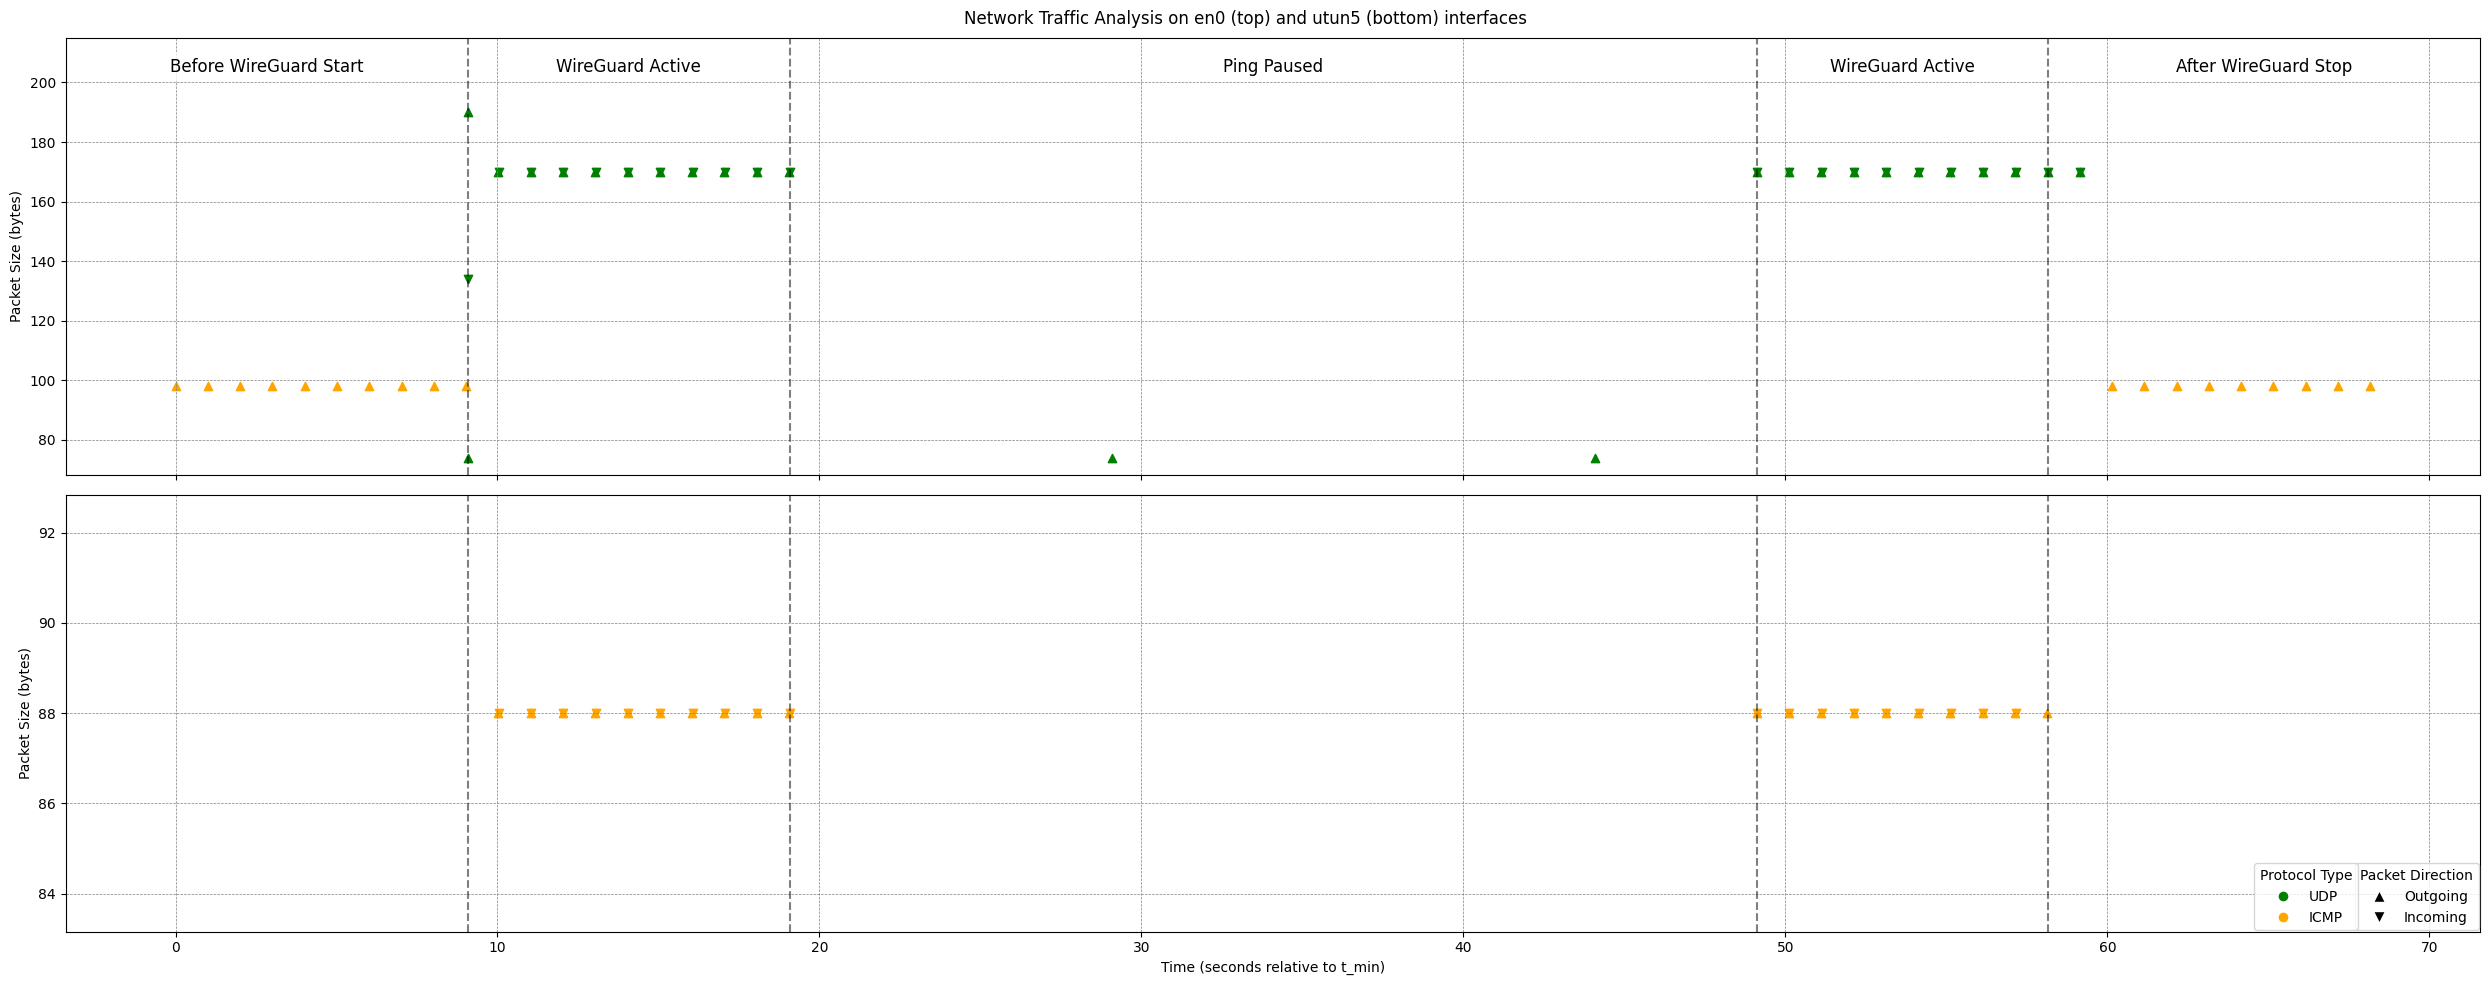

In [14]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Convert 'time' column from EDecimal to float
traffic['time'] = traffic['time'].astype(float)

# Calculate relative time in seconds
t_min = traffic['time'].min()
traffic['relative_time'] = traffic['time'] - t_min

# Define key events by index and get their times
wireguard_start_idx = 10
wireguard_stop_idx = 92
ping_pause_start_idx = 52  # Start of ping pause
ping_pause_stop_idx = 55   # End of ping pause

# Get the event times based on the indices
wireguard_start_time = traffic.loc[wireguard_start_idx, 'relative_time']
wireguard_stop_time = traffic.loc[wireguard_stop_idx, 'relative_time']
ping_pause_start_time = traffic.loc[ping_pause_start_idx, 'relative_time']
ping_pause_stop_time = traffic.loc[ping_pause_stop_idx, 'relative_time']

# Define protocol colors for easy differentiation
protocol_colors = {
    "UDP": "green",
    "ICMP": "orange",
}

# Plot settings
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10), sharex=True)
fig.suptitle("Network Traffic Analysis on en0 (top) and utun5 (bottom) interfaces")

# Scatter plot for en0 adapter
en0_data = traffic[traffic["adapter"] == "en0"]
for idx, row in en0_data.iterrows():
    marker = "^" if row["direction"] == "OUTGOING" else "v" if row["direction"] == "INCOMING" else "o"
    ax1.scatter(row["relative_time"], row["len"], color=protocol_colors.get(row["protocol"], "gray"), marker=marker)

ax1.set_ylabel("Packet Size (bytes)")
ax1.grid(True, linestyle="--", lw=0.5, color="gray")

# Scatter plot for utun5 adapter
utun5_data = traffic[traffic["adapter"] == "utun5"]
for idx, row in utun5_data.iterrows():
    marker = "^" if row["direction"] == "OUTGOING" else "v" if row["direction"] == "INCOMING" else "o"
    ax2.scatter(row["relative_time"], row["len"], color=protocol_colors.get(row["protocol"], "gray"), marker=marker)

ax2.set_xlabel("Time (seconds relative to t_min)")
ax2.set_ylabel("Packet Size (bytes)")
ax2.grid(True, linestyle="--", lw=0.5, color="gray")

# Add vertical lines for WireGuard events and ping pause
event_times = [wireguard_start_time, wireguard_stop_time, ping_pause_start_time, ping_pause_stop_time]
for event_time in event_times:
    ax1.axvline(event_time, linestyle="--", color="black", alpha=0.5)
    ax2.axvline(event_time, linestyle="--", color="black", alpha=0.5)

# Adjust x-limits to get the actual range for labels
plt.tight_layout()
plt.draw()  # Ensure the plot is rendered to get updated limits

# Define segment boundaries and labels
x_start, x_end = ax1.get_xlim()
event_times = [x_start, wireguard_start_time, ping_pause_start_time, ping_pause_stop_time, wireguard_stop_time, x_end]
segment_labels = [
    "Before WireGuard Start",
    "WireGuard Active",
    "Ping Paused",
    "WireGuard Active",
    "After WireGuard Stop"
]

# Adjust y-limits to make room for labels
ax1_ylim = ax1.get_ylim()
ax1.set_ylim(ax1_ylim[0], ax1_ylim[1] + (ax1_ylim[1] - ax1_ylim[0]) * 0.15)

# Calculate midpoints and place labels
for i in range(len(event_times) - 1):
    start_time = event_times[i]
    end_time = event_times[i + 1]
    mid_time = (start_time + end_time) / 2
    label = segment_labels[i]
    ax1.text(
        mid_time,
        ax1_ylim[1] + (ax1_ylim[1] - ax1_ylim[0]) * 0.05,  # Position label above the plot
        label,
        ha='center',
        va='bottom',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

# Add legends for packet direction and protocol colors, placed next to each other in lower right corner
direction_legend = [
    Line2D([0], [0], marker="^", color="w", markerfacecolor="black", markersize=8, label="Outgoing"),
    Line2D([0], [0], marker="v", color="w", markerfacecolor="black", markersize=8, label="Incoming")
]
protocol_legend = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=protocol_colors["UDP"], markersize=8, label="UDP"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor=protocol_colors["ICMP"], markersize=8, label="ICMP"),
]

# Create both legends and place them next to each other
first_legend = ax2.legend(
    handles=direction_legend,
    loc='lower right',
    bbox_to_anchor=(1, 0),
    borderaxespad=0.1,
    title='Packet Direction'
)

second_legend = ax2.legend(
    handles=protocol_legend,
    loc='lower right',
    bbox_to_anchor=(0.95, 0),
    borderaxespad=0.1,
    title='Protocol Type'
)

# Add the first legend back to the axes
ax2.add_artist(first_legend)

plt.tight_layout()
plt.show()

Before establishing the WireGuard connection, ICMP (ping) packets are sent from the client IP `192.168.188.65` to the server’s internal IP `10.0.0.1` over the `en0` interface, with no responses coming back from the server as expected since the server IP is outside the client’s local network. When the WireGuard connection is initiated, it follows a two-way handshake: the client sends a handshake initiation packet to the server’s external IP (`89.58.29.203`), and shortly after, the server responds with a handshake acknowledgment. The third packet, after the handshake, is a keep-alive message from the client to the server. This handshake and keep-alive process can be confirmed by examining the initial packets using Wireshark.

![Wireshark handshake analysis](wireshark_handshake.png)

Once the connection is established, subsequent ping requests follow a new path. The ICMP request, now unencrypted, originates from the `utun5` interface with a source IP of `10.0.0.2` and destination IP of `10.0.0.1`. This ICMP packet is then wrapped in an encrypted WireGuard UDP packet sent from `192.168.188.65` to `89.58.29.203` via the `en0` interface. The response first arrives on `en0`, where it’s decrypted and passed to `utun5` as an ICMP packet with the server IP as the source and the client’s WireGuard IP as the destination.



In [15]:
# Group data by direction and protocol, collect unique src and dst addresses, and count unique IPs
summary_data = (
    traffic.groupby(["adapter", "direction", "protocol"])
    .agg(
        src_ips=("src", lambda x: ', '.join(x.unique())),
        dst_ips=("dst", lambda x: ', '.join(x.unique())),
    )
    .reset_index()
)

# Separate summaries for each adapter, excluding the 'adapter' column
en0_summary = summary_data[summary_data["adapter"] == "en0"].drop(columns=["adapter"])
utun5_summary = summary_data[summary_data["adapter"] == "utun5"].drop(columns=["adapter"])

print("en0 Adapter Summary:")
display(en0_summary)

print("\nutun5 Adapter Summary:")
display(utun5_summary)


en0 Adapter Summary:


,direction,protocol,src_ips,dst_ips
0,INCOMING,UDP,89.58.29.203,192.168.188.65
1,OUTGOING,ICMP,192.168.188.65,10.0.0.1
2,OUTGOING,UDP,192.168.188.65,89.58.29.203



utun5 Adapter Summary:


,direction,protocol,src_ips,dst_ips
3,INCOMING,ICMP,10.0.0.1,10.0.0.2
4,OUTGOING,ICMP,10.0.0.2,10.0.0.1


During the ping pause, no traffic flows through `utun5`, but `en0` shows keep-alive packets every 15 seconds, maintaining the WireGuard connection.

![Wireshark ping pause analysis](wireshark_ping_pause.png)

After the WireGuard connection is terminated, traffic on `utun5` stops, while residual UDP packets on en0 appear to be remnants from the connection shutdown process. With the VPN disabled, ping requests revert to unencrypted ICMP messages on `en0`, from `192.168.188.65` to `10.0.0.1`, though no responses are received

Finally, we calculated the overhead introduced by the WireGuard protocol by comparing the size of ICMP ping messages sent and received on the `utun5` interface with their encapsulated, encrypted counterparts on `en0`. This comparison reveals the added packet size due to WireGuard’s encryption and encapsulation, providing a clear view of the protocol’s overhead.

In [16]:
# Extract relevant packet sizes from the traffic DataFrame
utun5_outgoing_size = traffic.loc[13, "len"]
en0_outgoing_size = traffic.loc[14, "len"]
en0_incoming_size = traffic.loc[15, "len"]
utun5_incoming_size = traffic.loc[16, "len"]

# Calculate outgoing and incoming WireGuard overhead
outgoing_overhead = en0_outgoing_size - utun5_outgoing_size
incoming_overhead = en0_incoming_size - utun5_incoming_size

# Display results
print(f"Outgoing WireGuard Overhead (utun5 -> en0): {outgoing_overhead} bytes")
print(f"Incoming WireGuard Overhead (en0 -> utun5): {incoming_overhead} bytes")


Outgoing WireGuard Overhead (utun5 -> en0): 82 bytes
Incoming WireGuard Overhead (en0 -> utun5): 82 bytes
